In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_excel('C:/Users/ncole/Downloads/Solar Sizing Data Complete.xlsx',index_col = 0,sheet_name = 'Sheet1',squeeze = True)
df2 = pd.read_excel('C:/Users/ncole/Documents/Python Things/REDB Copy.xlsx', sheet_name = 'Master', usecols = ['Address', 'Latitude', 'Longitude', 'Zip', 'ApplYear', 'ElecSoldTo'] )
df2.set_index('Address', inplace = True)
df.set_index('Address', inplace = True)
df2 = df2.loc[~df2.index.duplicated()]
df = df.loc[~df.index.duplicated()]

df_complete = pd.concat([df,df2], axis = 1, join = 'inner')
df_complete.index
#df_complete['Full Address'] = df2['Full Address']

Index(['988 High Rock Acres Drive', '6909 Sardis Green Court',
       '368 Trammel Gap Road', '1470 Midlake Avenue', '1985 Brevard Road',
       '1000 Exeter Field Circle', '122 Appaloosa Trail', '5 N Swain Street',
       '316 Seawell Avenue', '5825 Eastbrook Road',
       ...
       '105 Windsong Dr', '4840 Balsom Rd', '350 Kitchens Branch Rd',
       '3815 Cresent Ave', '7706 Gable Run Dr', '10809 Ashland Mill Ct',
       '1231 Guadalupe Lane', '901 Colt Circle', '5140 Casland Drive',
       '75 Bynum Hill'],
      dtype='object', name='Address', length=10099)

(10099, 22)
(8677, 22)


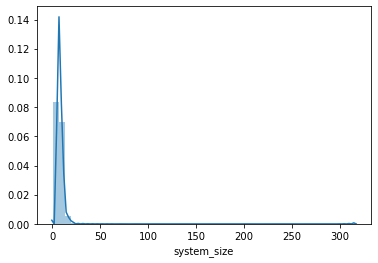

In [3]:
#df.drop('Unnamed:', axis = 1,inplace = True)
df_complete.head()

print(df_complete.shape)
#Filter outliers to prevent model overfitting
df_complete = df_complete[(df_complete['system_size'] < 20) & (df_complete['sqft'] >= 500)]
address = df_complete.index
print(df_complete.shape)
sns.distplot(df['system_size'])
y = df_complete['system_size'].values


Index(['sqft', 'yr_built', 'stories', 'improvementYear', 'system_size',
       'rooms', 'beds', 'baths', 'ApplYear', 'Latitude', 'Longitude'],
      dtype='object')


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

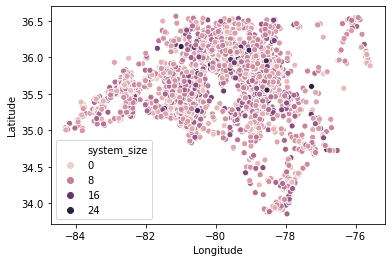

In [4]:
print(df_complete.corr()['system_size'].index)
df_complete.groupby('Zip')['system_size'].median().describe()
sns.scatterplot(x = 'Longitude', y = 'Latitude', hue = 'system_size', data = df_complete)

In [5]:
df_complete.drop(['improvementYear'],axis = 1, inplace=True)

#Remove outliers to get more accurate predictions


In [6]:
df_complete.corr()['system_size'].sort_values(ascending = False)

system_size    1.000000
sqft           0.373293
baths          0.255380
rooms          0.229672
beds           0.189819
yr_built       0.035508
Longitude      0.029184
stories        0.027008
Latitude       0.001583
ApplYear      -0.004189
Name: system_size, dtype: float64

In [7]:
#elec_sold_to = pd.get_dummies(df_complete['ElecSoldTo'])
#elec_sold_to = elec_sold_to[elec_sellers]
#elec_sold_to.corr(df_complete['system_size'])

In [8]:
#Want to do min-max-scaling prior to including categorical variables
numeric = df_complete.select_dtypes(include=np.number)
#numeric.drop('ApplYear',inplace = True, axis = 1)

for column in numeric.columns:
    if (numeric[column].isnull().sum()/len(numeric[column]) > .5):
           numeric.drop([column],axis = 1, inplace = True)
        
#numeric.info()

columns = numeric.columns.tolist()

#Fill nulls with median values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
df_numeric = imputer.fit_transform(numeric)
df_numeric = pd.DataFrame(data = df_numeric, columns = columns)


#Add Dummy variables to dataframe prior to numeric fitting
heating = pd.get_dummies(df_complete['heating'])
heating.rename(columns={'Yes': 'Has Heater', 'Unknown':'Heating Unclear', 'Central': 'Central Heating'},inplace = True)
heating['Address'] = address
heating.set_index('Address',inplace = True)
df_numeric['Address'] = address
df_numeric.set_index('Address',inplace = True)
df_ready = pd.concat([heating, df_numeric], axis = 1, join = 'inner')
df_ready.drop(['Latitude', 'Longitude'],inplace = True, axis = 1)
df_ready['pool'] = df_complete['pool'].apply(lambda x: 0.0 if pd.isna else 1.0)
df_ready.info()
X = df_ready

#Split data prior to numeric fitting
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#df_complete.drop('system_size',inplace = True, axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

#Scale numeric non-null feature columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


#df_numeric_final = pd.DataFrame(df_numeric_final, columns = columns)
#df_numeric_final['ApplYear'] = df_complete['ApplYear']
#df_numeric_final['Address'] = address
#df_numeric_final.info()

C:\Users\ncole\Anaconda3\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<class 'pandas.core.frame.DataFrame'>
Index: 8677 entries, 988 High Rock Acres Drive to 75 Bynum Hill
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Baseboard        8677 non-null   uint8  
 1   Central Heating  8677 non-null   uint8  
 2   Electric         8677 non-null   uint8  
 3   Floor Furnace    8677 non-null   uint8  
 4   Floor/Wall       8677 non-null   uint8  
 5   Forced Air       8677 non-null   uint8  
 6   Gravity          8677 non-null   uint8  
 7   Heat Pump        8677 non-null   uint8  
 8   Hot Water        8677 non-null   uint8  
 9   Radiant          8677 non-null   uint8  
 10  Solar            8677 non-null   uint8  
 11  Space Heater     8677 non-null   uint8  
 12  Steam            8677 non-null   uint8  
 13  Heating Unclear  8677 non-null   uint8  
 14  Has Heater       8677 non-null   uint8  
 15  sqft             8677 non-null   float64
 16  yr_built         8677 non-null  

In [9]:

#df_complete.corr()['system_size']
#df_complete['pool'].value_counts()

In [10]:
#df_complete.groupby('InstallerCompany')['system_size'].median().plot().bar()
#df_complete['cooling'].value_counts()
#df_complete['heating'].isnull().sum()



#cat_columns = np.setdiff1d(df_complete.columns, numeric.columns)
#for columns in cat_columns:
 #   print(columns)

In [11]:
df_complete.drop('style',inplace = True, axis = 1)

#df_complete.groupby('style')['system_size'].median().plot().bar()

#Want to create dummy variable dataframe for top 10 installers and then concatenate


df_complete = pd.concat([df_complete,pool_dummy],axis = 1)
#df = pd.concat([df,styles_dummy],axis=1)
df_complete = pd.concat([df_complete,cooling],axis=1)
df_complete = pd.concat([df_complete,heating],axis=1)

df_complete = pd.concat([df_complete,comp_dummy],axis=1)
df_complete = pd.concat([df_complete, elec_sold_to],axis = 1)

df_complete.corr()['system_size'].sort_values(ascending = False)[0:15]

In [12]:
#Cannot figure out how to keep the dataframe rows the same, while merging columns.
#Create dummy dataframe for heating type


In [13]:
#df_ready['pool'].describe()
#sns.heatmap(df_ready.corr(),annot=True)


In [14]:
#Want to drop columns with too many null values to reliably imput


In [15]:
#Replace Null values with median of column value

#X_train[:, 0:8] = imputer.transform(X_train[:, 0:3])

In [27]:
lm = LinearRegression()
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)

from sklearn import metrics 
print(metrics.mean_absolute_error(y_test, predictions)) 
print(metrics.mean_squared_error(y_test, predictions)) 
print(np.sqrt(metrics.mean_squared_error(y_test, predictions)))
#X.columns

5.2432030384928e-15
6.008855985191792e-29
7.751681098440384e-15


coeff_df = pd.DataFrame(data = lm.coef_, columns = df_ready.columns)
coeff_df

predictions = lm.predict(X_test)

plt.scatter(y_test,predictions)

sns.distplot((y_test-predictions),bins=50);

from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

df['system_size'].median()

#Testing LinearSVR turns out to be suboptimal solution
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR

param_grid = {'C':[.1, .5, 1, 10, 100], 'max_iter':[10,100,1000,1500], 'loss':['epsilon_insensitive', 'squared_epsilon_insensitive']}
grid = GridSearchCV(LinearSVR(),param_grid, verbose = 3)

#grid.best_estimator
grid.fit(X_train, y_train)

results = grid.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, results))
print('MSE:', metrics.mean_squared_error(y_test, results))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, results)))


grid.best_estimator_

#Test DecisionTree Regressor
from sklearn.tree import DecisionTreeRegressor
param_grid = {'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'], 'max_features': [2,4,6,8,10,12], 'min_samples_leaf':[2,10,50,100], 'max_depth': [None,3,5,10]}
grid = GridSearchCV(DecisionTreeRegressor(),param_grid,verbose=3)
grid.fit(X_train,y_train)


results = grid.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, results))
print('MSE:', metrics.mean_squared_error(y_test, results))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, results)))
grid.best_estimator_

from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt


param_grid = {'alpha': [0,.1,.3,.5,.75,1], 'max_iter': [100,500,1000,1500], 'normalize': [True,False]}
grid = GridSearchCV(Lasso(),param_grid)
grid.fit(X_train,y_train)


#plt.plot(range(len(X.columns)), coeffs)


params = grid.best_params_
coeffs = grid.best_estimator_.coef_
results = pd.DataFrame([list(coeffs)],columns= X.columns)
results.head()

int_cols = df_complete.dtypes[df_complete.dtypes.values == 'float64'].index.tolist()





X_train[best_cols] = X_train[best_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
X_test[best_cols] = X_test[best_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


datas = pd.DataFrame(X_train)
datas.columns

In [16]:
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(len(df_ready.columns),activation = 'relu'))
model.add(Dense(len(df_ready.columns),activation = 'relu'))
model.add(Dense(len(df_ready.columns),activation = 'relu'))
#model.add(Dense(10, activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')
model.fit(x=X_train, y=y_train, validation_data = (X_test, y_test), batch_size = 128, epochs = 200)

Epoch 1/200
48/48 [==============================] - 1s 8ms/step - loss: 52.8266 - val_loss: 24.9631
Epoch 2/200
48/48 [==============================] - 0s 2ms/step - loss: 16.0685 - val_loss: 6.8174
Epoch 3/200
48/48 [==============================] - 0s 2ms/step - loss: 6.9377 - val_loss: 6.3212
Epoch 4/200
48/48 [==============================] - 0s 2ms/step - loss: 6.3727 - val_loss: 5.8125
Epoch 5/200
48/48 [==============================] - 0s 2ms/step - loss: 5.8265 - val_loss: 4.4301
Epoch 6/200
48/48 [==============================] - 0s 2ms/step - loss: 4.1314 - val_loss: 2.5377
Epoch 7/200
48/48 [==============================] - 0s 2ms/step - loss: 2.2061 - val_loss: 0.8664
Epoch 8/200
48/48 [==============================] - 0s 2ms/step - loss: 0.7130 - val_loss: 0.2197
Epoch 9/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1441 - val_loss: 0.0920
Epoch 10/200
48/48 [==============================] - 0s 2ms/step - loss: 0.0693 - val_loss: 0.0514
Epoch 

48/48 [==============================] - 0s 1ms/step - loss: 5.5509e-05 - val_loss: 0.0075
Epoch 81/200
48/48 [==============================] - 0s 2ms/step - loss: 8.8692e-05 - val_loss: 0.0074
Epoch 82/200
48/48 [==============================] - 0s 1ms/step - loss: 6.7817e-05 - val_loss: 0.0074
Epoch 83/200
48/48 [==============================] - 0s 2ms/step - loss: 1.2497e-04 - val_loss: 0.0074
Epoch 84/200
48/48 [==============================] - 0s 2ms/step - loss: 9.2454e-05 - val_loss: 0.0075
Epoch 85/200
48/48 [==============================] - 0s 2ms/step - loss: 8.3653e-05 - val_loss: 0.0075
Epoch 86/200
48/48 [==============================] - 0s 2ms/step - loss: 5.7435e-05 - val_loss: 0.0075
Epoch 87/200
48/48 [==============================] - 0s 2ms/step - loss: 6.3963e-05 - val_loss: 0.0074
Epoch 88/200
48/48 [==============================] - 0s 2ms/step - loss: 8.1480e-05 - val_loss: 0.0075
Epoch 89/200
48/48 [==============================] - 0s 2ms/step - loss: 6.4

48/48 [==============================] - 0s 2ms/step - loss: 7.3272e-05 - val_loss: 0.0076
Epoch 159/200
48/48 [==============================] - 0s 2ms/step - loss: 8.5653e-05 - val_loss: 0.0074
Epoch 160/200
48/48 [==============================] - 0s 2ms/step - loss: 3.4923e-05 - val_loss: 0.0076
Epoch 161/200
48/48 [==============================] - 0s 2ms/step - loss: 1.4093e-04 - val_loss: 0.0074
Epoch 162/200
48/48 [==============================] - 0s 2ms/step - loss: 1.2911e-04 - val_loss: 0.0090
Epoch 163/200
48/48 [==============================] - 0s 2ms/step - loss: 9.4825e-04 - val_loss: 0.0074
Epoch 164/200
48/48 [==============================] - 0s 2ms/step - loss: 9.7976e-05 - val_loss: 0.0076
Epoch 165/200
48/48 [==============================] - 0s 2ms/step - loss: 2.6930e-04 - val_loss: 0.0074
Epoch 166/200
48/48 [==============================] - 0s 1ms/step - loss: 9.0165e-05 - val_loss: 0.0074
Epoch 167/200
48/48 [==============================] - 0s 2ms/step - 

82/82 [==============================] - 0s 546us/step - loss: 0.0074


0.007429696619510651

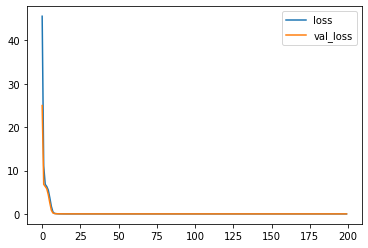

In [17]:
df_loss = pd.DataFrame(model.history.history)
df_loss.plot()

model.evaluate(X_test, y_test)

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

In [19]:
predictions = model.predict(X_test)
np.sqrt(mean_squared_error(y_test,predictions))/(np.median(y_test))

0.012140237897346926

In [20]:
mean_absolute_error(y_test,predictions)

0.014611397090229235

In [21]:
explained_variance_score(y_test, predictions)

0.9991588194424148

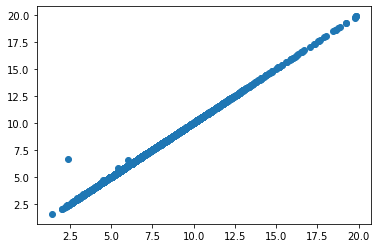

In [22]:
plt.scatter(y_test,predictions)